# 02_exploratory_analysis.ipynb

**Что делаю в этом ноутбуке:**
- Смотрю базовые статистики по train
- Строю диаграммы распределения и boxplot для ключевых признаков
- Провожу корреляционный анализ (heatmap)
- Даю краткие выводы

In [1]:
# Создаём папку для графиков/метрик
from pathlib import Path

ARTIFACTS_DIR = Path("../artifacts") 

ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
print("Artifacts dir:", ARTIFACTS_DIR.resolve())

Artifacts dir: C:\Users\Admin\Heart-Disease-Prediction\artifacts


In [2]:
from typing import Sequence, Optional, Dict
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline

df = pd.read_csv("../data/processed/train_preprocessed.csv")
print("Форма train:", df.shape)
display(df.head())

Форма train: (600000, 22)


,ID,age,resting_blood_pressure,serum_cholestoral,maximum_heart_rate_achieved,oldpeak,class,sex_1,chest_2,chest_3,...,resting_electrocardiographic_results_1,resting_electrocardiographic_results_2,exercise_induced_angina_1,slope_2,slope_3,number_of_major_vessels_1,number_of_major_vessels_2,number_of_major_vessels_3,thal_6,thal_7
0,0,49,163,181,148,0.944547,1,0,0,0,...,0,0,1,1,0,0,0,0,0,0
1,1,54,130,276,153,0.119070,0,1,1,0,...,0,1,0,1,0,0,0,0,0,0
2,2,50,147,223,102,1.616747,1,1,0,0,...,0,1,1,1,0,0,1,0,0,1
3,3,59,112,187,158,0.000000,1,1,0,0,...,0,0,1,0,0,1,0,0,0,1
4,4,51,138,238,173,1.150464,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0


Списки признаков для визуализации

In [3]:
FEATURE_LABELS = {
    'age': "Возраст",
    'resting_blood_pressure': "Давление в покое",
    'serum_cholestoral': "Холестерин",
    'maximum_heart_rate_achieved': "Макс. ЧСС",
    'oldpeak': "ST-депрессия",
    'sex_1': "Пол: 1 — муж., 0 — жен.",
    'fasting_blood_sugar_1': "Глюкоза натощак >120: 1 — да, 0 — нет",
    'resting_electrocardiographic_results_1': "ЭКГ тип 1",
    'resting_electrocardiographic_results_2': "ЭКГ тип 2",
    'exercise_induced_angina_1': "Ст. при нагрузке: 1 — да, 0 — нет",
    'slope_2': "Slope = 2",
    'slope_3': "Slope = 3",
    'number_of_major_vessels_1': "Сосудов = 1",
    'number_of_major_vessels_2': "Сосудов = 2",
    'number_of_major_vessels_3': "Сосудов = 3",
    'thal_6': "Thal = 6 (фикс. дефект)",
    'thal_7': "Thal = 7 (обр. дефект)",
    'class': "Наличие болезни (target)"
}

num_cols = [
    'age', 'resting_blood_pressure', 'serum_cholestoral',
    'maximum_heart_rate_achieved', 'oldpeak'
]
cat_cols = [c for c in df.columns if c.endswith(("_1","_2","_3","_6","_7"))]

Функция для гистограмм количественных признаков

In [4]:
def plot_histograms(
    data: pd.DataFrame,
    columns: Sequence[str],
    bins: int = 30,
    labels: Optional[Dict[str, str]] = None,
    save_dir: Optional[str] = None,
) -> None:
    """Гистограммы для числовых признаков."""
    for col in columns:
        plt.figure(figsize=(6, 3))
        sns.histplot(data[col], bins=bins, color="#500EDE", edgecolor="black")
        title = labels.get(col, col) if labels else col
        plt.title(f"Распределение: {title}")
        plt.xlabel(title); plt.ylabel("Частота")
        plt.tight_layout()
        if save_dir: plt.savefig(os.path.join(save_dir, f"hist_{col}.png"), dpi=120, bbox_inches="tight")
        plt.show()

Функция для boxplot

In [5]:
def plot_boxplots(
    data: pd.DataFrame,
    columns: Sequence[str],
    labels: Optional[Dict[str, str]] = None,
    save_dir: Optional[str] = None,
) -> None:
    """Boxplot`ы для оценки выбросов."""
    for col in columns:
        plt.figure(figsize=(6, 3))
        sns.boxplot(x=data[col], color="#500EDE")
        title = labels.get(col, col) if labels else col
        plt.title(f"Box-plot: {title}")
        plt.xlabel(title)
        plt.tight_layout()
        if save_dir: plt.savefig(os.path.join(save_dir, f"box_{col}.png"), dpi=120, bbox_inches="tight")
        plt.show()

Функция для barplot по dummy/категориальным признакам

In [6]:
def plot_barplots(
    data: pd.DataFrame,
    columns: Sequence[str],
    labels: Optional[Dict[str, str]] = None,
    save_dir: Optional[str] = None,
) -> None:
    """Barplot’ы для бинарных/категориальных dummy-признаков."""
    for col in columns:
        if data[col].nunique() <= 10:
            plt.figure(figsize=(5, 2))
            vc = data[col].value_counts().sort_index()
            ax = vc.plot(kind="bar", color="#500EDE", edgecolor="black")
            if sorted(vc.index.tolist()) == [0, 1]:
                ax.set_xticklabels(["0 - Нет", "1 - Да"], rotation=0)
            else:
                ax.set_xticklabels(vc.index, rotation=0)
            title = labels.get(col, col) if labels else col
            plt.title(f"Частоты: {title}")
            plt.xlabel(title); plt.ylabel("Частота")
            plt.tight_layout()
            if save_dir: plt.savefig(os.path.join(save_dir, f"bar_{col}.png"), dpi=120, bbox_inches="tight")
            plt.show()

Корреляционная матрица только для количественных фич + target

In [7]:
def plot_corr_heatmap(
    data: pd.DataFrame,
    cols: Sequence[str],
    labels: Optional[Dict[str, str]] = None,
    target_col: str = "class",
    annot: bool = True,
    save_path: Optional[str] = None,
):
    """Heatmap корреляций по числовым признакам (+ target)."""
    corr = data[list(cols) + [target_col]].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    display_labels = [labels.get(c, c) if labels else c for c in corr.columns]

    plt.figure(figsize=(7, 6))
    sns.heatmap(
        corr, mask=mask, annot=annot, fmt=".2f", center=0, cmap="coolwarm",
        square=True, linewidths=.5, cbar_kws={"shrink": .8},
        xticklabels=display_labels, yticklabels=display_labels
    )
    plt.title("Корреляционная матрица (количественные)")
    plt.tight_layout()
    if save_path: plt.savefig(save_path, dpi=120, bbox_inches="tight")
    plt.show()

    if target_col in corr.columns:
        tc = corr[target_col].drop(target_col)
        print("\nТоп-5 по |corr| с target:");  print(tc.abs().sort_values(ascending=False).head(5))
        print("\nТоп-5 отрицательных corr с target:"); print(tc.sort_values().head(5))
        return tc.abs().sort_values(ascending=False)
    return corr

Функция для диаграммы рассеяния

In [8]:
def plot_scatter(
    data: pd.DataFrame,
    x: str,
    y: str,
    hue: str = "class",
    alpha: float = 0.25,
    save_path: Optional[str] = None,
) -> None:
    """Классический scatter числовой-на-числовой."""
    plt.figure(figsize=(7, 5))
    sns.scatterplot(data=data, x=x, y=y, hue=hue, alpha=alpha, edgecolor=None)
    plt.title(f"Scatter: {x} vs {y}")
    plt.tight_layout()
    if save_path: plt.savefig(save_path, dpi=120, bbox_inches="tight")
    plt.show()

Функция для PCA

In [9]:
def plot_pca_scatter(
    data: pd.DataFrame,
    features: Sequence[str],
    target_col: str = "class",
    n_components: int = 2,
    figsize: tuple[int, int] = (8, 6),
    save_path: Optional[str] = None,
) -> None:
    """Scatter по первым двум компонентам PCA"""
    X = data[list(features)].values
    y = data[target_col].values if target_col in data.columns else None
    Xs = StandardScaler().fit_transform(X)
    Xp = PCA(n_components=n_components, random_state=42).fit_transform(Xs)

    plt.figure(figsize=figsize)
    sc = plt.scatter(Xp[:, 0], Xp[:, 1], c=y, cmap="coolwarm", alpha=0.3, s=10, edgecolors="none")
    plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title("PCA")
    if y is not None: plt.colorbar(sc, label="Класс (0/1)")
    plt.tight_layout()
    if save_path: plt.savefig(save_path, dpi=120, bbox_inches="tight")
    plt.show()

Визуализация 

Гистограммы количественных признаков


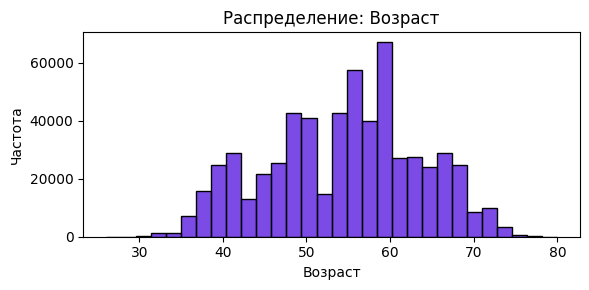

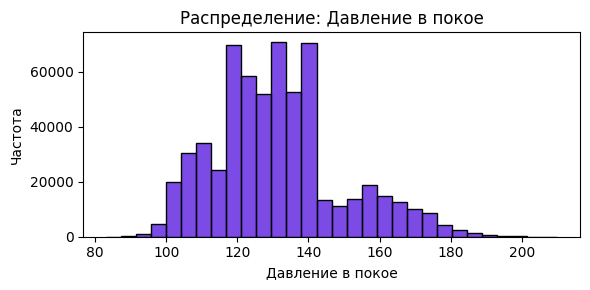

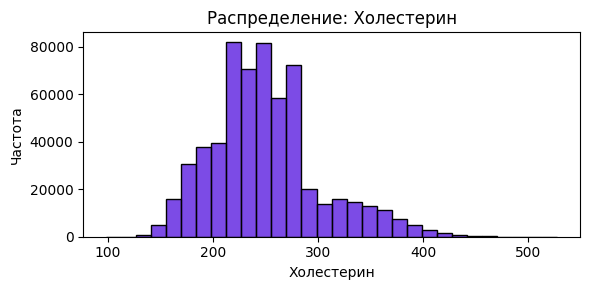

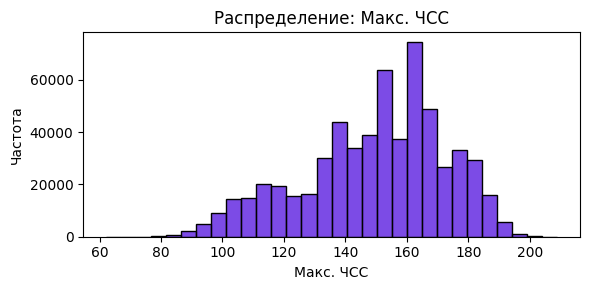

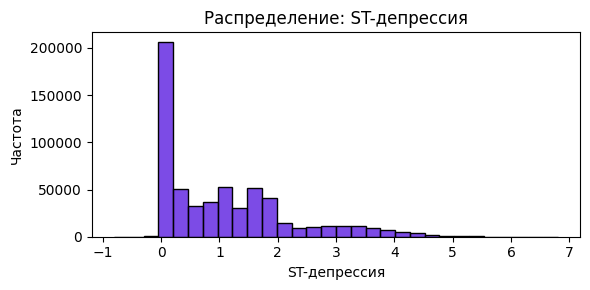

Boxplot количественных признаков


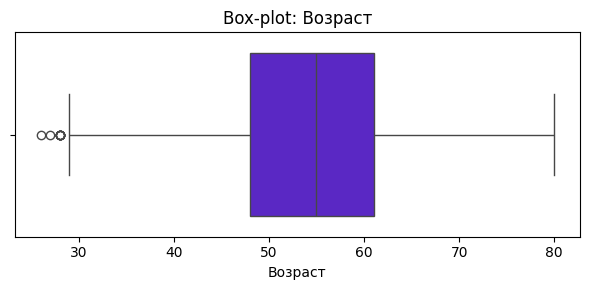

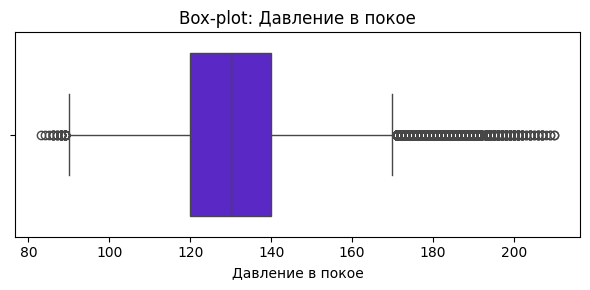

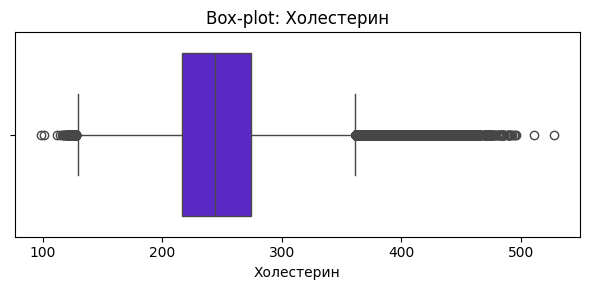

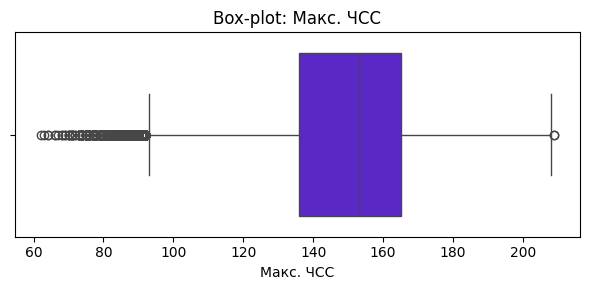

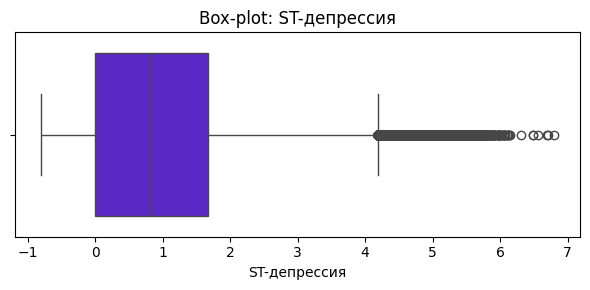

Barplot по dummy/категориальным фичам


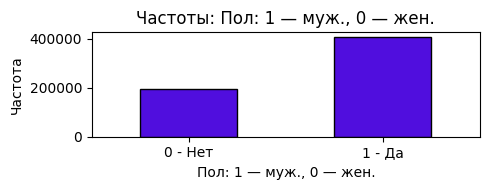

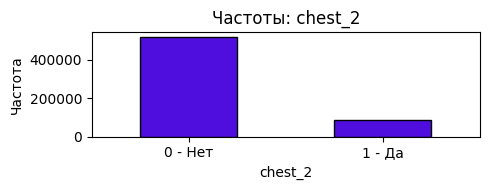

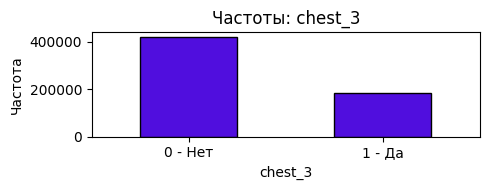

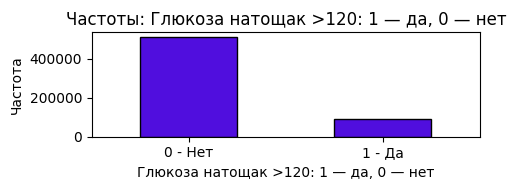

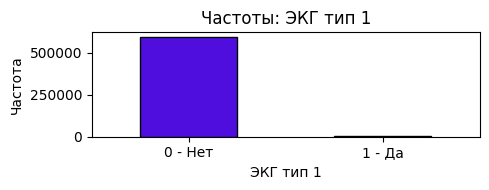

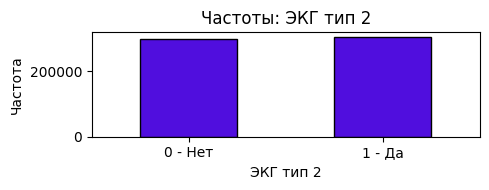

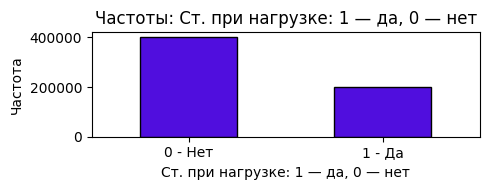

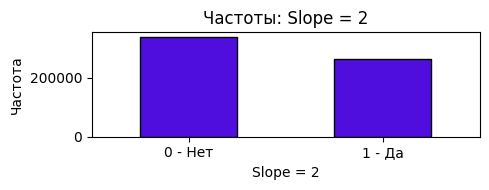

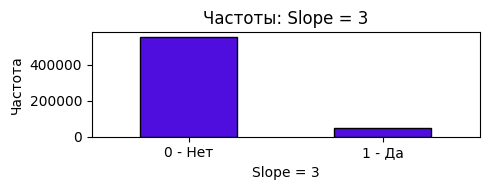

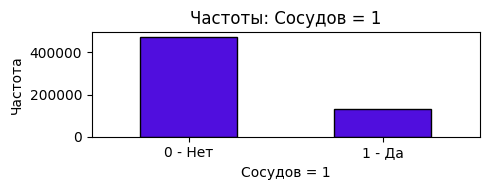

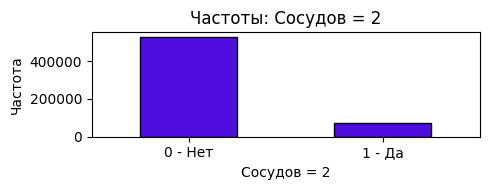

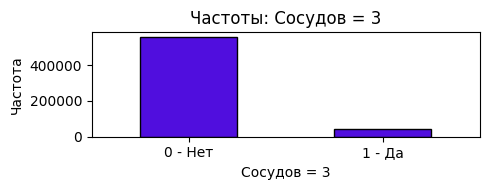

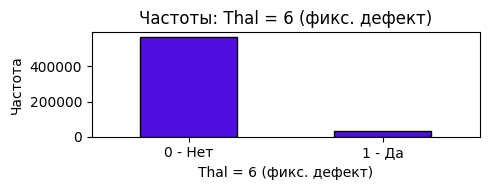

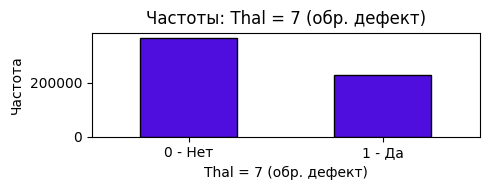

Корреляционная матрица и топ-5 признаков


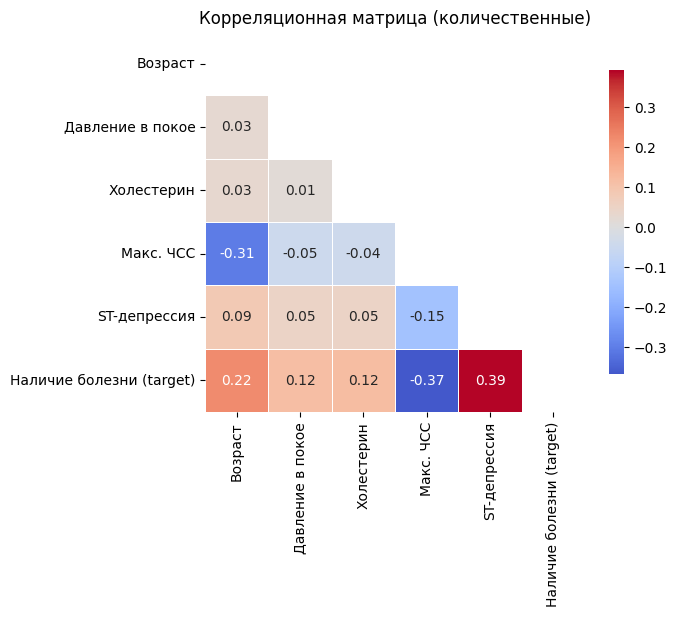


Топ-5 по |corr| с target:
oldpeak                        0.392788
maximum_heart_rate_achieved    0.368732
age                            0.221936
serum_cholestoral              0.117776
resting_blood_pressure         0.115011
Name: class, dtype: float64

Топ-5 отрицательных corr с target:
maximum_heart_rate_achieved   -0.368732
resting_blood_pressure         0.115011
serum_cholestoral              0.117776
age                            0.221936
oldpeak                        0.392788
Name: class, dtype: float64
Диаграмма рассеяния


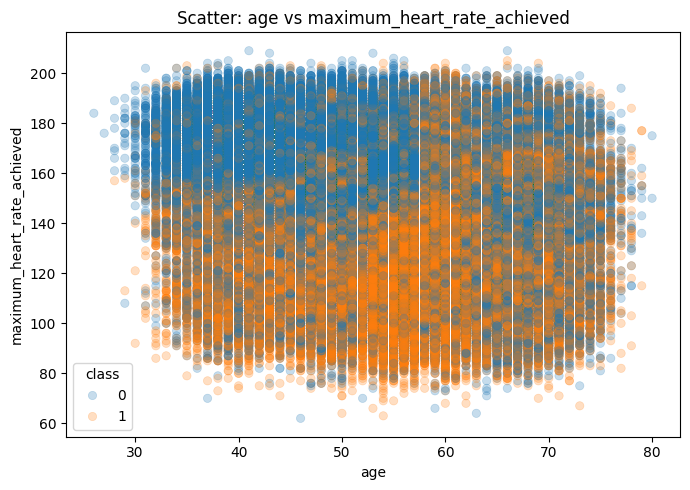

PCA визуализация


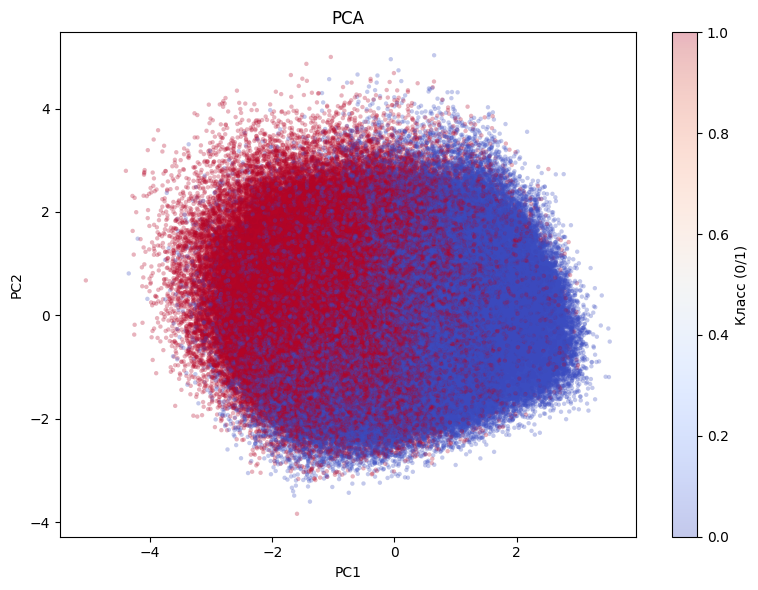

In [10]:
print("Гистограммы количественных признаков")
plot_histograms(df, num_cols, labels=FEATURE_LABELS, save_dir="../artifacts")

print("Boxplot количественных признаков")
plot_boxplots(df, num_cols, labels=FEATURE_LABELS, save_dir="../artifacts")

print("Barplot по dummy/категориальным фичам")
plot_barplots(df, cat_cols, labels=FEATURE_LABELS, save_dir="../artifacts")

print("Корреляционная матрица и топ-5 признаков")
_ = plot_corr_heatmap(
    df, num_cols, labels=FEATURE_LABELS, target_col="class",
    annot=True, save_path="../artifacts/corr_heatmap.png"
)

print("Диаграмма рассеяния")
plot_scatter(
    df, x="age", y="maximum_heart_rate_achieved",
    save_path="../artifacts/scatter_age_maxhr.png"
)

print("PCA визуализация")
plot_pca_scatter(
    df, num_cols, target_col="class",
    save_path="../artifacts/pca_scatter.png"
)

 Как видно, явного разделения по классам нет: здоровые и больные пациенты распределены почти равномерно. Это значит, что ни один признак или их простая линейная комбинация не отделяет классы полностью - задача требует сложных моделей и ансамблей. 
 
 Тем не менее, есть небольшие сдвиги в плотности: "больные" чаще попадают в зону с низкой максимальной ЧСС и высокой ST-депрессией что соотвествует корреляционному анализу выше.

Такой результат ожидаем для медицинских данных: диагноз строится на комбинации многих факторов

## Итоги EDA

**Датасет:** `train_preprocessed.csv` (после очистки и приведения типов).  
**Графики:** гистограммы, boxplot’ы, barplot’ы, heatmap корреляций, scatter, PCA — сохранены в `artifacts/`.

### 1) Количественные признаки — распределения и выбросы
- **Возраст (`age`)** — близко к нормальному, пик ~55–60; немного нижних выбросов (<30).
- **Давление в покое (`resting_blood_pressure`)** — мода ~120–140; правый хвост до ~200, правые выбросы.
- **Холестерин (`serum_cholestoral`)** — выраженная правосторонняя асимметрия; хвост до ~520, много правых выбросов.
- **Макс. ЧСС (`maximum_heart_rate_achieved`)** — центр ~150–170; выбросы снизу (60–90) и немного сверху (>190).
- **ST-депрессия (`oldpeak`)** — сильно правоскошное распределение (много нулей/малых значений), длинный правый хвост (до ~6–7), множество правых выбросов.

> **Вывод:** выбросы выглядят физиологично и укладываются в допустимые диапазоны. Удалять не требуется; для LogReg/NN — использовать `StandardScaler`/`RobustScaler`.

### 2) Категориальные (по barplot’ам после OHE)
- **Пол (`sex_1`)** — мужчин существенно больше (~2/3).
- **Боль в груди:** `chest_3` встречается заметно чаще `chest_2` (последняя редкая); базовый `chest_1` скрыт OHE.
- **Глюкоза натощак >120 (`fasting_blood_sugar_1`)** — редкая категория.
- **ЭКГ в покое:** `restecg_1` — очень редкая; `restecg_2` сопоставим по частоте с базовым 0.
- **Стенокардия при нагрузке (`exercise_induced_angina_1`)** — "Да" заметно реже "Нет", но не единично.
- **Наклон ST-сегмента:** `slope_2` — частая; `slope_3` - редкая; базовый `slope_1` - оставшаяся доля.
- **Крупные сосуды:** `number_of_major_vessels_1` — заметная доля; `_2`, `_3` — реже (монотонное убывание).
- **Thal:** присутствуют `thal_6`, `thal_7` (меньшинство); базовый `thal_3`.

> **Замечание:** есть **редкие уровни** (`restecg_1`, `slope_3`, `fbs_1`, `chest_2`).
- Для устойчивости - регуляризация в LogReg и ансамбли (RF). 
- Объединение редких уровней можно не делать из-за большого объёма данных.

### 3) Корреляции и взаимосвязи
- По heatmap (числовые + `class`) ожидаемые связи:
  - **`oldpeak`** — одна из самых сильных **положительных** связей с таргетом (больше депрессия - выше риск).
  - **`maximum_heart_rate_achieved`** — **отрицательная** связь (выше достижимая ЧСС - ниже риск).
  - **`age`** — слабая положительная связь.
  - **`resting_blood_pressure`, `serum_cholestoral`** — слабые связи с таргетом.
- Классический **scatter** (`age` vs `maximum_heart_rate_achieved`) подтверждает нисходящий тренд с окраской по `class`.
- **PCA (стандартизованные числовые):** умеренная перекрываемость классов - полностью линейно разделить нельзя; ожидаемо выигрывают нелинейные модели/ансамбли.

### 4) Импликации для моделирования
- **Предобработка:** масштабировать числовые (для LogReg/NN); OHE уже выполнен. `ID` не подавать в обучение.
- **Модели:** LogReg (с регуляризацией и `class_weight=balanced`), RandomForest (нечувствителен к масштабу/выбросам), MLP (с ранней остановкой и `pos_weight` при дисбалансе).
- **Валидация и метрики:** стратифицированная CV; основные - ROC-AUC, PR-AUC; дополнительно - accuracy/F1 и матрица ошибок.

**Итог:** данные после предобработки выглядят корректно и согласованно с клиническими ожиданиями. 

- EDA подтверждает информативность `oldpeak`, `maximum_heart_rate_achieved` и ряда категориальных признаков (тип боли в груди, стенокардия при нагрузке, `thal`). 

Переходим к обучению и сравнению моделей.